In [25]:

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df=pd.read_csv(r'D:\Documents\Python Code\K-means\cluster_2.csv')

score = np.array(df["atm_score"])


time = np.array(df["timein"])

sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100



x = score

# Error standard deviation. 
sigma_n = 0.4
# Errors.
# epsilon = np.random.normal(loc=0, scale=sigma_n, size=n)
# Observed target variable. 
y = time


# Define kernel parameters. 
l = 0.1
sigma_f = 2

# Define kernel object. 
kernel = ConstantKernel(constant_value=sigma_f,constant_value_bounds=(1e-9, 1e9)) \
            * RBF(length_scale=l, length_scale_bounds=(1e-9, 1e9))

X = x.reshape(-1,1)
x_star = score
X_star = x_star.reshape(-1,1)



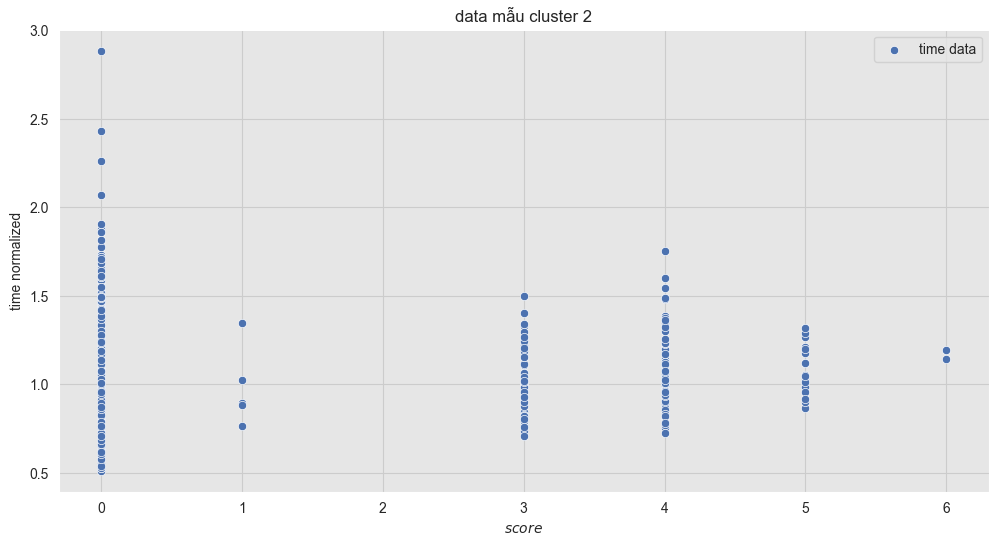

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.xlabel("$score$")
plt.ylabel('time normalized')
sns.scatterplot(x=x, y=y, label='time data', ax=ax)
ax.set_title('data mẫu cluster 2')
ax.legend(loc='upper right');

In [27]:
def kernel_function(x, y, sigma_f=2, l=0.1):
    """Define squared exponential kernel function."""
    kernel = sigma_f * np.exp(- (np.linalg.norm(x - y)**2) / (2 * l**2))
    return kernel

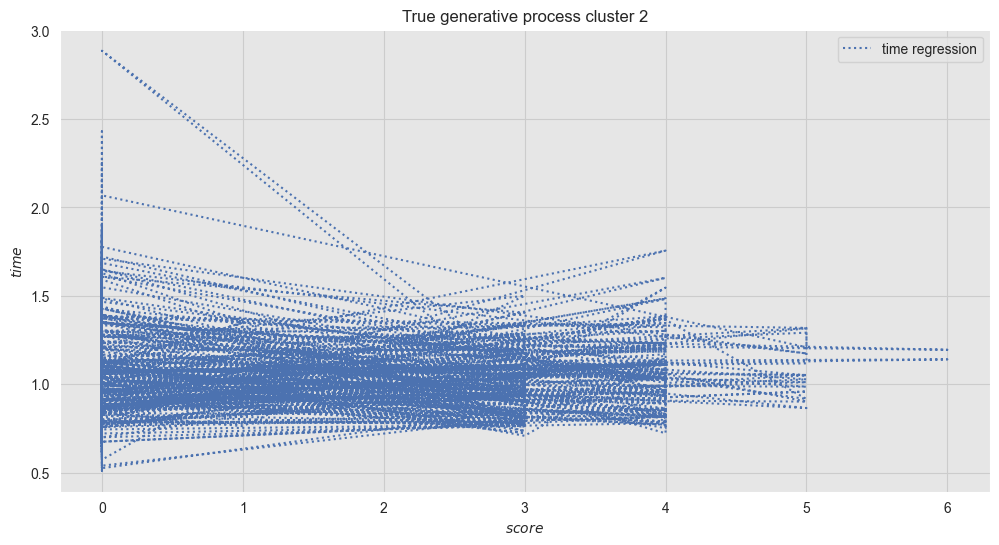

In [28]:
import matplotlib.pyplot as plt

plt.plot(X, y, label=r'time regression', linestyle="dotted")
plt.legend()
plt.xlabel("$score$")
plt.ylabel("$time$")
_ = plt.title("True generative process cluster 2")

In [29]:
from functools import partial
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy.optimize

class MyGPR(GaussianProcessRegressor):
    def __init__(self, *args, max_iter=15000, **kwargs):
        super().__init__(*args, **kwargs)
        self._max_iter = max_iter

    def _constrained_optimization(self, obj_func, initial_theta, bounds):
        def new_optimizer(obj_func, initial_theta, bounds):
            return scipy.optimize.minimize(
                obj_func,
                initial_theta,
                method="L-BFGS-B",
                jac=True,
                bounds=bounds,
                max_iter=self._max_iter,
            )
        self.optimizer = new_optimizer
        return super()._constrained_optimization(obj_func, initial_theta, bounds)

In [30]:
from sklearn.gaussian_process import GaussianProcessRegressor
# Define GaussianProcessRegressor object. 
gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_n**2, n_restarts_optimizer=10)
gp.fit(X, y)

GaussianProcessRegressor(alpha=0.16000000000000003,
                         kernel=1.41**2 * RBF(length_scale=0.1),
                         n_restarts_optimizer=10)

In [24]:
print(x.shape)

(2546,)


In [22]:
print(X.shape)

(2546, 1)


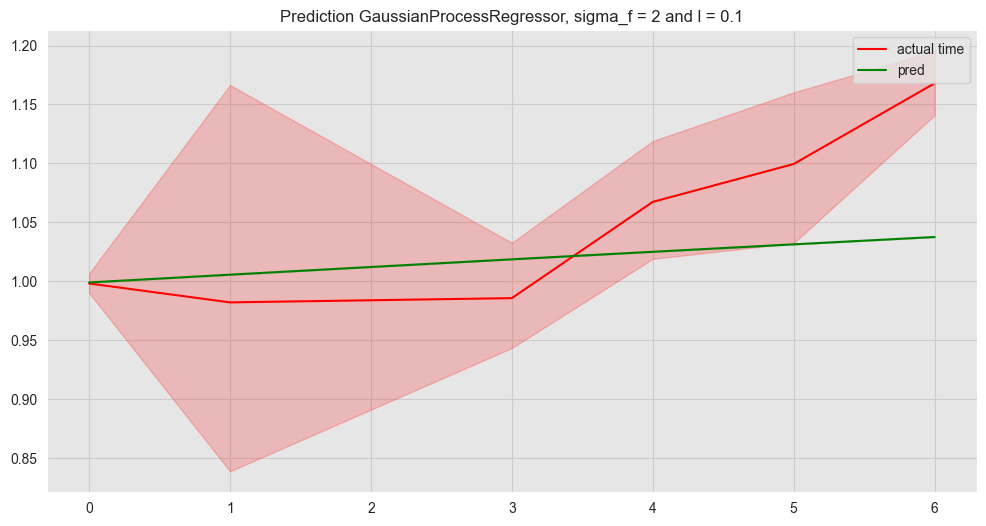

In [31]:
# Make the prediction on test set.
y_pred = gp.predict(X)

fig, ax = plt.subplots()
# Plot "true" linear fit.
sns.lineplot(x=x, y=y, color='red', label='actual time', ax=ax)
# Plot prediction. 
sns.lineplot(x=x, y=y_pred, color='green', label='pred', ax=ax)
ax.set(title=f'Prediction GaussianProcessRegressor, sigma_f = {sigma_f} and l = {l}')
ax.legend(loc='upper right');


In [32]:
def compute_gpr_parameters(K, K_star2, K_star, sigma_n):
    """Compute gaussian regression parameters."""
    n = K.shape[0]
    d=1
    # Mean.
    f_bar_star = np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), y.reshape([n, d])))
    # Covariance.
    cov_f_star = K_star2 - np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), K_star.T))
    
    return (f_bar_star, cov_f_star)

In [34]:
import itertools

def compute_cov_matrices(x, x_star, sigma_f=2, l=0.1):
    """
    Compute components of the covariance matrix of the joint distribution.
    
    We follow the notation:
    
        - K = K(X, X) 
        - K_star = K(X_*, X)
        - K_star2 = K(X_*, X_*)
    """
    n = x.shape[0]
    n_star = x_star.shape[0]

    K = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(x, x)]

    K = np.array(K).reshape(n, n)
    
    K_star2 = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(x_star, x_star)]

    K_star2 = np.array(K_star2).reshape(n_star, n_star)
    
    K_star = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(x_star, x)]

    K_star = np.array(K_star).reshape(n_star, n)
    
    return (K, K_star2, K_star)

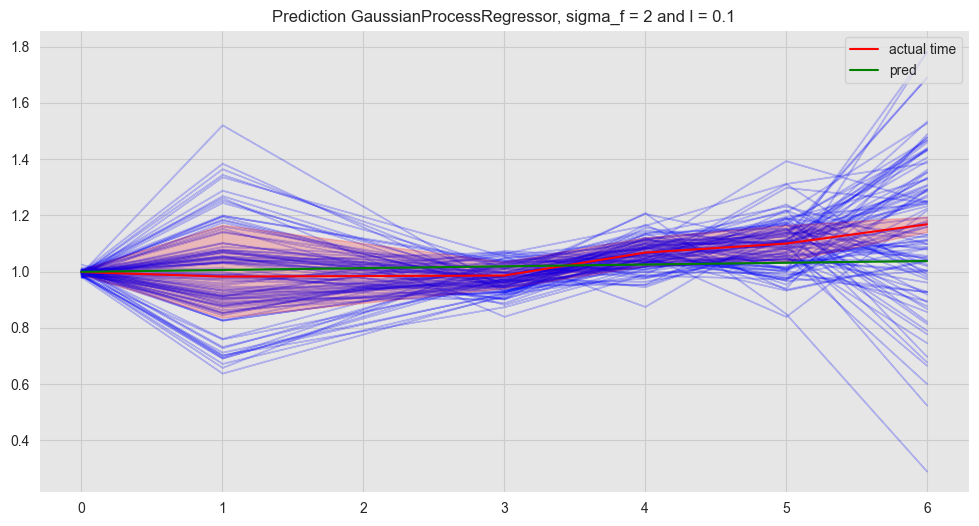

In [35]:
K, K_star2, K_star = compute_cov_matrices(x, x_star, sigma_f = sigma_f, l = l)

f_bar_star, cov_f_star = compute_gpr_parameters(K, K_star2, K_star, sigma_n)

fig, ax = plt.subplots()

for i in range(0, 100):
    # Sample from posterior distribution. 
    z_star = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star)
    # Plot function.
    sns.lineplot(x=x_star, y=z_star, color='blue', alpha=0.05, ax=ax);
    
# Plot "true" linear fit.
sns.lineplot(x=x, y=y, color='red', label='actual time', ax=ax);
# Plot prediction. 
sns.lineplot(x=x_star, y=y_pred, color='green', label='pred', ax=ax);
ax.set(title=f'Prediction GaussianProcessRegressor, sigma_f = {sigma_f} and l = {l}')
ax.legend(loc='upper right');

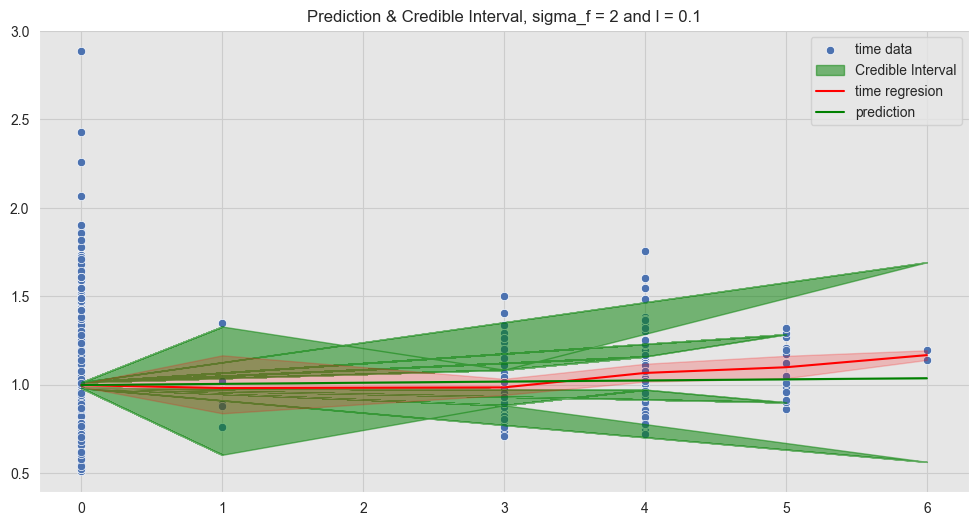

In [36]:
# Generate samples from posterior distribution. 
y_hat_samples = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star, size=1000)
# Compute the mean of the sample. 
y_hat = np.apply_over_axes(func=np.mean, a=y_hat_samples, axes=0).squeeze()
# Compute the standard deviation of the sample. 
y_hat_sd = np.apply_over_axes(func=np.std, a=y_hat_samples, axes=0).squeeze()
fig, ax = plt.subplots()
# Plot training data.
sns.scatterplot(x=x, y=y, label='time data', ax=ax)
# Plot corridor. 
ax.fill_between(
    x=x_star, 
    y1=(y_hat - 2*y_hat_sd), 
    y2=(y_hat + 2*y_hat_sd), 
    color='green', 
    alpha = 0.5, 
    label='Credible Interval'
)
# Plot "true" linear fit.
sns.lineplot(x=x, y=y, color='red', label='time regresion', ax=ax);
# Plot prediction. 
sns.lineplot(x=x_star, y=y_pred, color='green', label='prediction', ax=ax)
ax.set_title('Prediction & Credible Interval, sigma_f = {} and l = {}'.format(sigma_f, l))
ax.legend(loc='upper right');